# CODECADEMY WALKTHROUGH: DATE A SCIENTIST

Get ready for the third act of this walkthrough for Codecademy's Data Science career path.\
We will apply machine learning algorithms to the *OkCupid Date a Scientist* dataset for completing the *machine learning portfolio project*.

## Exploratory Data Analysis and Data Preparation
Data are provided by Codecademy as part of the project in a file named `profiles.csv`.\
The dataset provided has the following columns of multiple-choice data:
- **body_type**
- **diet**
- **drinks**
- **drugs**
- **education**
- **ethnicity**
- **height**
- **income**
- **job**
- **offspring**
- **orientation**
- **pets**
- **religion**
- **sex**
- **sign**
- **smokes**
- **speaks**
- **status**

And a set of open short-answer responses to :
- **essay0**: *My self-summary*
- **essay1**: *What I’m doing with my life*
- **essay2**: *I’m really good at…*
- **essay3**: *The first thing people usually notice about me…*
- **essay4**: *Favorite books, movies, show, music, and food*
- **essay5**: *The six things I could never do without*
- **essay6**: *I spend a lot of time thinking about…*
- **essay7**: *On a typical Friday night I am…*
- **essay8**: *The most private thing I am willing to admit*
- **essay9**: *You should message me if…*

I already have a faint idea of what I'm interested in: I would like to make prediction on people age by using essays available on users profiles.\
For this reason I will focus the *exploratory data analysis* on tidying ages essays and users.

### Import statements
As usual, we start by importing all the relevant packages.

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

# Increase columns limit
#pd.options.display.max_columns = None

### Load CSV
Let's now load *OkCupid* users profiles and assign them to a *pandas dataframe*.\
The first row of profiles' table is visible below.

In [2]:
# Load profiles
profiles = pd.read_csv('profiles.csv')
display(profiles.head(1))

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single


We may improve `profiles` by changing the essays columns names. Something related to the subject of each essay would be more intuitive.

In addition some *HTML* charachters are present inside texts: we can remove them with *RegEx*.\
I noticed that the RegEx expression I choosed is sensible to newlines charachters, which may prevent *HTML tag removal* if `\n` is inside the tag itself. Let's remove them before working on those pesky *HTML* tags!

In [3]:
# Replace essay columns names with something meaningful
profiles.rename(columns={'essay0': 'my_self', 'essay1': 'life', 'essay2': 'good_at', 'essay3': 'people_notice', 
                         'essay4': 'favorites', 'essay5': 'six_needed', 'essay6': 'think_to', 'essay7': 'friday_night', 
                         'essay8': 'private_admit', 'essay9': 'message_me_if'}, inplace=True)

# Save a list with essay columns names
essays_cols = profiles.columns.to_list()[6:16]

# Remove newlines and HTML charachters from essay columns
for col in essays_cols:
    profiles[col] = profiles[col].str.replace("\n", " ", regex=False)
    profiles[col] = profiles[col].str.replace(r"<[^>]*>", "", regex=True)

display(profiles.head(1))
    
print(f"DATAFRAME LENGTH: {len(profiles)} rows")

,age,body_type,diet,drinks,drugs,education,my_self,life,good_at,people_notice,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single


DATAFRAME LENGTH: 59946 rows


Texts are good to go now.\
This dataframe includes 59946 users, a considerable amount.

### Dataset basic description
Before moving to the age distribution let'see if we have missing values in essays.

In [4]:
# Find missing data only for essays columns
missing_df = profiles.iloc[:,6:16].isna().sum(axis=0).to_frame()
# Show results
missing_df.rename(columns={0: 'missing_count'}, inplace=True)
display(missing_df.style.set_caption('Missing essays'))

,missing_count
my_self,5488
life,7572
good_at,9638
people_notice,11476
favorites,10537
six_needed,10850
think_to,13771
friday_night,12451
private_admit,19225
message_me_if,12603


Ok, now we know that it is better to remove *NaNs* if we are going to train a model on this dataset:\
some people did not completed all the essays...

Texts are finally clean, we can take a look to age distribution.

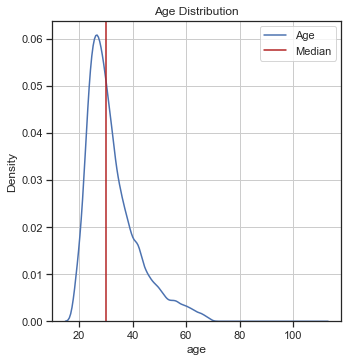

MEDIAN: 30.0


In [5]:
# Theme preferences (used for every plot)
sns.set_theme(style='ticks', rc={'axes.grid': True})


# Age distribution plotting function (with median)
def print_age_dist(median):
    sns.displot(profiles, x="age", kind="kde")
    sns.despine(top=False, right=False)
    plt.axvline(median, color='firebrick')
    plt.title('Age Distribution')
    plt.legend(['Age', 'Median'])
    plt.show()

# Find median
median = profiles.age.median()

print_age_dist(median)

print(f'MEDIAN: {median:.1f}')

Age median is *30* and there is a peak around 25. We see also that the distribution is right skewed, this means that in our dataset a reduced number of people is more than 40 years old.

Looking at the far right of the ditribution plot, it seems that we have some people over 100 years old.
This is unexpected!

In [6]:
display(profiles[profiles.age > 100])

,age,body_type,diet,drinks,drugs,education,my_self,life,good_at,people_notice,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
2512,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"daly city, california",NaN,straight,NaN,NaN,f,NaN,NaN,english,single
25324,109,athletic,mostly other,NaN,never,working on masters program,NaN,NaN,NaN,nothing,...,"san francisco, california",might want kids,straight,NaN,other and somewhat serious about it,m,aquarius but it doesn&rsquo;t matter,when drinking,english (okay),available


Since these profiles are not meaningful, we can remove them.

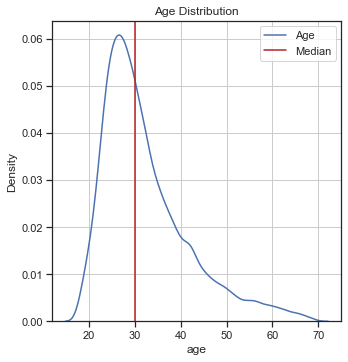

MEDIAN: 30.0


In [7]:
# Remove values
profiles = profiles[profiles.age <= 100]
# Find median and plot distribution
median = profiles.age.median()
print_age_dist(median)
print(f'MEDIAN: {median:.1f}')

I doubt that an *OkCupid* profile is accepted without the *age* field properly filled in, but it worth a check.

In [8]:
missing_df.rename(columns={0: 'missing_count'}, inplace=True)
print(f"MISSING AGES: {profiles.age.isna().sum()}")

MISSING AGES: 0


As expected, there is no need to handle missing ages.

## Scope of Project
Writing skills vary with age: we change our style, we express different interests and typically we use different espressions as we growth older.\
Is a *machine learning model* able of recognizing these age-related differences and classifying the age of each user?

Just to keep it simple I will apply my model to only one essay.\
The basic assumption is that younger and older people spend their friday evening in a different way and texts should reflect this difference.\
For this reason, I will focus my analysis on *essay n. 7*: 
> On a typical Friday night I am…

My goal is to assess if this approach could work: it is a first attempt rather than an extended analysis.

### Word Vectors and Age Labels
The [*Spacy*](https://spacy.io) package gives access to pre-trained *NLP* model. We will use the `en_core_web_lg` model for transforming words inside text in numerical vectors.

**Note:** *do not forget to download* `en_core_web_lg` *before proceeding, see instructions in* `README.md`.

In [9]:
nlp = spacy.load("en_core_web_lg")

After loading the model, *Friday essays* are isolated and rows with missing data are removed.\
Finally word vectors are evaluated (be patient, this may take some minutes).

In [10]:
# Selected essay (On a typical Friday night I am…)
essay_n = 7

# Remove NaNs
data = profiles[['age', essays_cols[essay_n]]].dropna().reset_index(drop=True)

# Calculate essay vectors
data['vector'] = [nlp(essay).vector for essay in tqdm(data[essays_cols[essay_n]], 
                                                      desc='Create vectors', 
                                                      unit='vect', 
                                                      mininterval=0.5,
                                                      leave=True)]

Create vectors:   0%|          | 0/47495 [00:00<?, ?vect/s]

Each essay is now described by an *average* word vector.\
We will find if this description is sufficient for correctly classifying users' age.

An `age_label` is created as target for classification:
- if age is less than 45, the class is `young`
- if age is over 45 the class is `old`

Anyway, I do not think that all the people over 45 years of age are *old* in a real sense. No judgment here, the threshold is set to be as closer as possible to *common sense* and to include a meaningful number of individuals from the given dataset.

In [11]:
data['age_label'] = data.age.apply(lambda a: 'young' if a<45 else 'old')
display(data.head(5))
display(data.age_label.value_counts().to_frame('count').style.set_caption('Young vs Old'))

,age,friday_night,vector,age_label
0,22,trying to find someone to hang out with. i am ...,"[0.06319867, 0.18136252, -0.2940689, 0.0234103...",young
1,38,viewing. listening. dancing. talking. drinking...,"[-0.0060819215, 0.1005275, -0.17452693, -0.284...",young
2,29,out with my friends!,"[0.0033432008, 0.099414006, -0.221234, 0.00564...",young
3,32,plotting to take over the world with my army o...,"[0.010795735, 0.02149141, -0.13075618, -0.0928...",young
4,31,out and about or relaxing at home with a good ...,"[-0.020128159, 0.27537325, -0.21100785, 0.0290...",young


,count
young,42189
old,5306


We know that the dataset is strongly imbalanced toward young people, I would expect this to be a problem for the classifier.

### Classification Model
We are ready to build a *modelization pipeline*. It includes the following steps:
- `scaler`: a `StandardScale`for removing scale effects
- `analyzer`: a `PCA` (principal component analysis) to reduce features dimensionality
- `classifier`: a `LogisticRegression` model for associating vectors to *age labels*

I have selected those components because they are fast to train.\
I then decided to add the *PCA* to reduce the dimensionality of vectors build by the large *Spacy* model (`en_core_web_lg`). These are 300 elements long!\
The *PCA* is set to keep only the principal components that explain 95 % of the variance.

Before training the pipeline, one third of the dataset is stored for testing the model later on.

`GridSearchCV` will train several `LogisticRegression` classifiers on different sub-datasets and with different hyperparameters, in order to find the best one according to our scoring metric.\
I selected `C` and `class_weight` as hyperparameters to be optimized (see [*Scikit* documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details).

`scoring`is set to `f1_weighted` instead of the default `accuracy` because we have an imbalanced dataset, where `young` people are dominant.
A simple *accuracy* would reward models that result often in a `young` classification, even if wrong.\
We want to penalize misclassification instead, and the score metrics we have selected attempts to reach that goal (see [*Scikit Learn*](https://scikit-learn.org/stable/modules/model_evaluation.html) documentation and this [*tour of evaluation metrics*](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)).

Tuning the `class_weight` hyperparameter is part of the same objective: in fact it assign different weights to errors on labels prediction. We are thus emphatizing the importance of the `old` class.

Time to train!\
**Please be patient, this will take a couple of minutes...**

In [12]:
# Set random state
rand_st = 125

# Set features and labels
features = np.vstack(data.vector.to_numpy())
labels = data.age_label.to_numpy()

# Divide in train and test set
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            stratify=labels,
                                                                            test_size=0.3, 
                                                                            random_state=rand_st)

# Define pipeline
pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 ('analyzer', PCA(random_state=rand_st, n_components=0.95, svd_solver= 'full')),
                 ('classifier', LogisticRegression())
                ])

# Parameters of grid search:
param_grid = {
              'classifier__C': [0.1, 0.15, 0.2, 0.3, 0.4],
              'classifier__class_weight': [{'young': y, 'old': o} for y, o in zip([1]*9, range(1,10))]
             }

# Grid search
grid = GridSearchCV(pipe,
                    param_grid,
                    scoring='f1_weighted',
                    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=rand_st),
                    n_jobs=-1,
                    verbose=1)

grid.fit(features_train, labels_train)

print(f"Best parameter (CV score={grid.best_score_:.3f}):")
print(grid.best_params_)

Fitting 6 folds for each of 45 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.0min finished


Best parameter (CV score=0.847):
{'classifier__C': 0.15, 'classifier__class_weight': {'young': 1, 'old': 3}}


The score seems good, we will see how good after the testing phase.\
We can see the effects of PCA dimensionality reduction with the following code.

In [13]:
print(f"Dimensions before PCA:\t{grid.best_estimator_['analyzer'].n_features_}")
print(f"Dimensions after PCA:\t{grid.best_estimator_['classifier'].n_features_in_}")

Dimensions before PCA:	300
Dimensions after PCA:	164


### Test
We have a sub-set we have kept for testing the model: it's time to use it!\
Score and confusion matrix are shown below.

In [14]:
# Model predictions
predictions = grid.predict(features_test)

# Score
test_score = grid.score(features_test, labels_test)
print(f"Test score: {test_score:.3f}")

# Confusion matrix
act_pred_df = pd.DataFrame({'actual': labels_test, 'predictions': predictions})
confusion_matrix = pd.crosstab(act_pred_df.actual, act_pred_df.predictions)
display(confusion_matrix)

Test score: 0.847


predictions,old,young
actual,,
old,300,1292
young,680,11977


As we expected the fact that the dataset is not balanced is problematic. The model tend to label *old* people as *young*.\
We see also that *young* people is sometimes labeled as *old*.

## Conclusions
The classifier match the dataset, at least partially.\
It seems also that it is not completely able of understanding the difference between essays written by *young* and *old* people: the reason of this beahvior may be that some vectorized essays are really similar between the two classes. Styling differences in written texts for the two groups are probably subtile in some cases, making harder for this model to understand them.\
It may happen also that some sentences are used frequently by both classes because they are generic and not age-related. This may lead to misclassifications too.

But is our classifier better than a trivial one, a model that predicts always the most frequent *young* label (called [*Zero Rule* or *ZeroR*](https://machinelearningcatalogue.com/algorithm/alg_zero-rule.html))?

Let' use *Scikit*'s `DummyClassifier` to output the most frequent label and evaluate the weighted *f1 score* of our model on the test set.\
It is possible to pass to `f1_score` a simple list made of `'young'` strings, instead of using the `DummyClassifier.predict` method.

In [15]:
# Train a dummy model that predict the most frequent label (0-rule)
dummy_model = DummyClassifier(strategy='most_frequent', random_state=rand_st)
dummy_model.fit(features_train, labels_train)
dummy_predict = dummy_model.predict(features_test)
score = f1_score(labels_test, dummy_predict, average='weighted')
print(f'ZeroR f1 score: {score:.3f}')

ZeroR f1 score: 0.836


The model we trained achieved an improved score of 0.886, so it has a value for the domain we have analyzed.

## Next Steps
I experimented different classifiers and several scoring function before adopting the simple pipeline described above.\
I wanted to test if the idea of recognizing age-related differences in texts and classify the author with those findings could work.\
For this reason I selected a classification algorithm that is fast and simple and then I played with scoring functions and hyperparameters to avoid biases towards the *young* class.\
Since there is a sensible improvement in comparison to the *Zero Rule*, it may worth investigating some possible improvements:
- Experimenting with different classifiers (e.g. kNN or other time intensive classifiers)
- Using a different scoring metric (I tested also `balanced_accuracy` which seemed to predict more *old* labels correctly but with higher misclassification on the *young* ones)
- Adding essays or features to help the model differentiating the two classes
- Adding a middle class with an intermediate age range